In [17]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) 

In [18]:
#define the metric we will use to measure similarity
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class WeightedKNN:

    def __init__(self, K=3, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K #radius
        return
    
    def fit(self, x, y):
        self.x = x #store the training data using this method as it is a lazy learner
        self.y = y
        self.C = np.max(y) + 1 #number of classes
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        n_test = x_test.shape[0]
        #next calculate the distance between every pair of training and test points (why?)
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:]) # n_test x n_train
        y_prob = np.zeros((n_test, self.C)) #keeps the probabilities for each class
        knns = np.zeros((n_test, self.K), dtype=int) # index of k nearest neighbours to each test point
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((n_test, self.C))

        # find indices of k nearest neighbors
        knns = np.argsort(distances, axis=1)[:, :self.K]

        knn_distances = distances[np.arange(n_test)[:, None], knns]

        epsilon = 1e-5
        weights = 1.0 / (knn_distances + epsilon)

        # get labels of k nearest neighbors
        knn_labels = self.y[knns]

        np.add.at(y_prob, (np.arange(n_test)[:, None], knn_labels), weights)

        # normalize y_prob to sum to 1 for each test point
        y_prob /= np.sum(y_prob, axis=1, keepdims=True)

y        return y_prob, knnsy

Next we use this method to classify face images. We use the *Olivetti face dataset*. The dataset contains 400 images of 40 people -- that is we have 10 images for each person. Each image is `64x64` and single channel (grayscale).

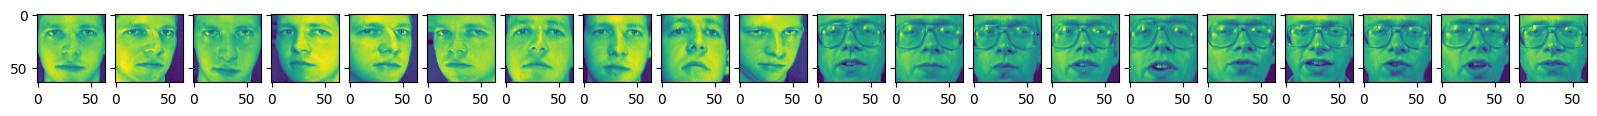

In [19]:
from sklearn import datasets 
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it befoer 

x,y = datasets.fetch_olivetti_faces(return_X_y=True)
def plot_images(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((64,64)))
    plt.show()
plot_images(x[:20]) 

Below, we plot the 10 nearest neighbours to the first face image above. We see that a few of closest neighbours can be used to classify the face image.

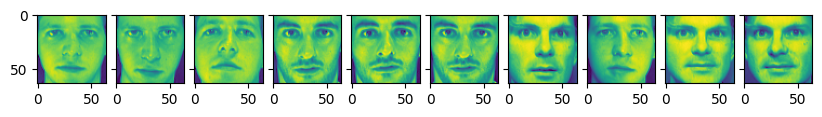

In [20]:
_, neighbours = WeightedKNN(K=10).fit(x,y).predict(x[[0]])
plot_images(x[neighbours[0]])

Shuffle the dataset and use 20% of the data for validation. Report the best hyper-parameter `K` using the validation set. You can use helper functions from `scikit-learn`.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#split the data with 20% for validation
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42, shuffle=True
)

best_acc = 0
best_k = None

for K in range(1, 21):  # trying K from 1 to 20
    model = WeightedKNN(K=K)
    model.fit(x_train, y_train)
    y_prob, _ = model.predict(x_val)
    y_pred = np.argmax(y_prob, axis=1)
    acc = accuracy_score(y_val, y_pred)
    print(f'Validation accuracy for K={K}: {acc*100:.2f}%')
    if acc > best_acc:
        best_acc = acc
        best_k = K

print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

Validation accuracy for K=1: 91.25%
Validation accuracy for K=2: 91.25%
Validation accuracy for K=3: 91.25%
Validation accuracy for K=4: 88.75%
Validation accuracy for K=5: 87.50%
Validation accuracy for K=6: 88.75%
Validation accuracy for K=7: 85.00%
Validation accuracy for K=8: 85.00%
Validation accuracy for K=9: 82.50%
Validation accuracy for K=10: 80.00%
Validation accuracy for K=11: 76.25%
Validation accuracy for K=12: 75.00%
Validation accuracy for K=13: 71.25%
Validation accuracy for K=14: 70.00%
Validation accuracy for K=15: 70.00%
Validation accuracy for K=16: 71.25%
Validation accuracy for K=17: 70.00%
Validation accuracy for K=18: 68.75%
Validation accuracy for K=19: 65.00%
Validation accuracy for K=20: 66.25%
best validation accuracy is 91.25 percent, using k=1


## Problem 2. Principal Component Analysis (6 pts)

### 2.a.) Eigenfaces (2)
For this assignment, we will find the principle compomponents of the face dataset, these are the eigenvectors of the covariance matrix, and sometimes called *eigenfaces* for face datasets.
Perform PCA and plot the first 20 eigenfaces. To do PCA you can either use the method discussed in the class (i.e., find the eigenvectors of the covariance matrix), or use the method explained in bonus slides, which uses Singular Value Decomposition (SVD), and is more stable. 

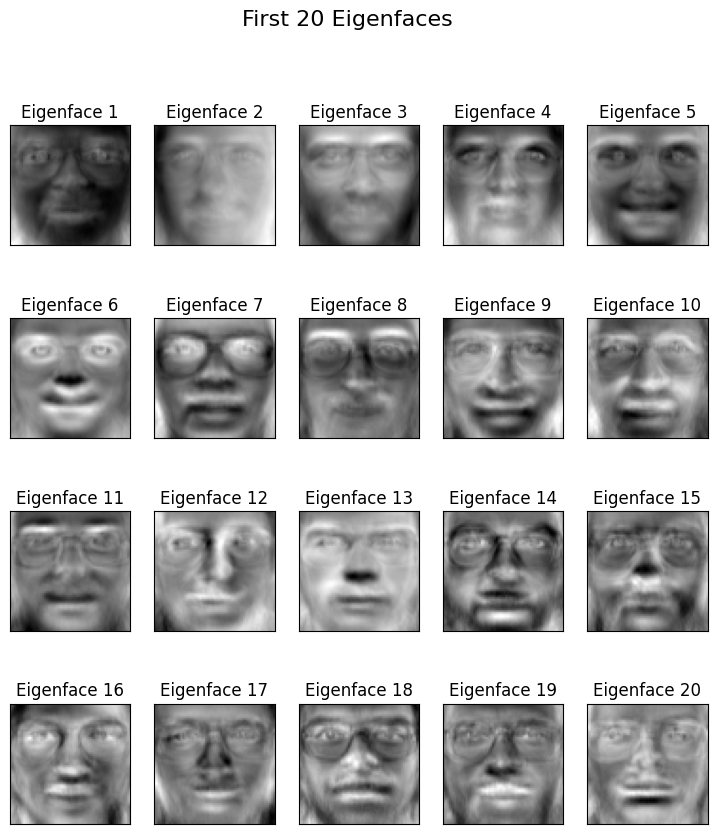

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

x, y = datasets.fetch_olivetti_faces(return_X_y=True)

# compute the mean face
mean_face = np.mean(x, axis=0)

x_centered = x - mean_face

# perform svd
U, S, Vt = np.linalg.svd(x_centered, full_matrices=False)

eigenfaces = Vt[:20]  # get the first 20 eigenfaces

# made a function to plot the eigenfaces
def plot_eigenfaces(eigenfaces, h=64, w=64, n_row=4, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.suptitle('First 20 Eigenfaces', fontsize=16)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(eigenfaces[i].reshape((h, w)), cmap='gray')
        plt.title(f"Eigenface {i+1}")
        plt.xticks(())
        plt.yticks(())
    plt.show()

# plot the first 20 eigenfaces
plot_eigenfaces(eigenfaces)



### 2.b) Picking the number of principal components (2 pts)
Plot the total amount variance explained versus the number of principal components.
Exactly how many principal components are needed to explain 95% of the variance in the data?

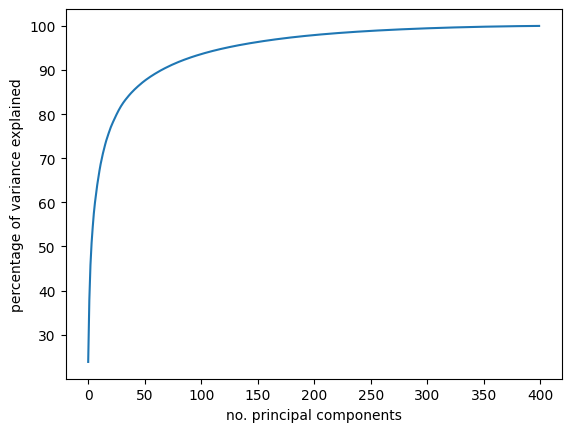

95% of the variance is explained using 123 principal components


In [23]:
variance_explained = (S ** 2) / np.sum(S ** 2)

cumulative_variance_explained = np.cumsum(variance_explained)

var_explained = cumulative_variance_explained * 100

# finding the number of principal components that explain 95% of the variance
L = np.argmax(cumulative_variance_explained >= 0.95) + 1

plt.plot(var_explained)
plt.xlabel("no. principal components")
plt.ylabel("percentage of variance explained")
plt.show()
print(f'95% of the variance is explained using {L} principal components')

### 2.C) Classification using embeddings (2pts)
Use the `WeightedKNN` of previous question to do classification in the embedding space of PCA. Use 100 principal components, and optimize for the choice of K in the range $K \in \{1,\ldots,10\}$. 
This means instead of storing the entire data, we can store its compressed form as vectors of length 100, while maintaining the accuracy. Note that the portion of the code that performs hyper-parameter tuning is identical to what you have above.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x, y = datasets.fetch_olivetti_faces(return_X_y=True)

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42, shuffle=True
)

# compute the mean face
mean_face = np.mean(x_train, axis=0)

x_train_centered = x_train - mean_face
x_val_centered = x_val - mean_face

# perform svd
U, S, Vt = np.linalg.svd(x_train_centered, full_matrices=False)

num_components = 100
eigenfaces = Vt[:num_components]

x_train_pca = np.dot(x_train_centered, eigenfaces.T)
x_val_pca = np.dot(x_val_centered, eigenfaces.T)

best_acc = 0
best_k = None

# different values of k to find best hyperparameter
for K in range(1, 11):  # trying K from 1 to 10
    model = WeightedKNN(K=K)
    model.fit(x_train_pca, y_train)
    y_prob, _ = model.predict(x_val_pca)
    y_pred = np.argmax(y_prob, axis=1)
    acc = accuracy_score(y_val, y_pred)
    print(f'Validation accuracy for K={K}: {acc*100:.2f}%')
    if acc > best_acc:
        best_acc = acc
        best_k = K

print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

Validation accuracy for K=1: 91.25%
Validation accuracy for K=2: 91.25%
Validation accuracy for K=3: 90.00%
Validation accuracy for K=4: 88.75%
Validation accuracy for K=5: 85.00%
Validation accuracy for K=6: 86.25%
Validation accuracy for K=7: 82.50%
Validation accuracy for K=8: 82.50%
Validation accuracy for K=9: 83.75%
Validation accuracy for K=10: 80.00%
best validation accuracy is 91.25 percent, using k=1


## 3) K-Means clustering (2.5 pts) Solution provided
Use the `KMeans` class from `scikit-learn` to cluster the data into K=40 clusters. Use other default values in the `scikit-learn` implementation. Plot the images for 5 out of 40 clusters. Note that this is not a question but an example of application of clustering, provided for demonstration.

cluster 0


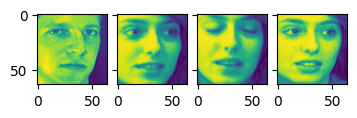

cluster 1


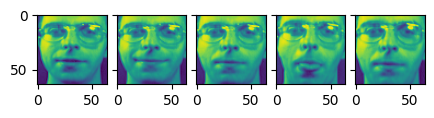

cluster 2


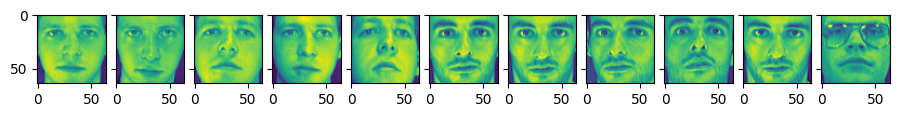

cluster 3


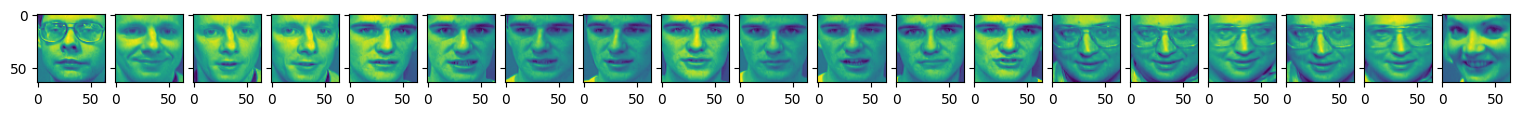

cluster 4


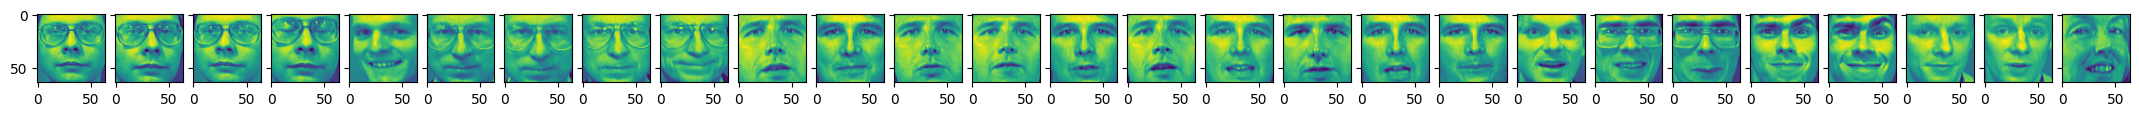

In [25]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=40).fit(x)
y_cluster = kmeans.predict(x)
for c in range(5):
    print(f'cluster {c}')
    plot_images(x[y_cluster == c])
